# Sunspot Prediction Model

Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.
(Source: [Wikipedia](https://en.wikipedia.org/wiki/Sunspot))


### Content
This data contains Monthly Mean Total Sunspot Number from 1749/01/01 to 2018/07/31

### Acknowledgements

SIDC and Quandl.

Database from SIDC - Solar Influences Data Analysis Center - the solar physics research department of the Royal Observatory of Belgium. [SIDC website](https://www.sidc.be)

## Import Libraries

In [1]:
# import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pickle

2025-02-13 14:59:46.391606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download and Preview the Dataset

In [2]:
# Install wget using homebrew
!brew install wget

==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
To reinstall 1.25.0, run:
  brew reinstall wget


Download the dataset. This dataset is based on Sunspot data found on [Kaggle](https://www.kaggle.com/datasets/robervalt/sunspots). The stored dataset is modified from the Kaggle's dataset by Laurence Moroney in Coursera. 

In [3]:
# Download the Dataset
!wget -nc https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

File ‘Sunspots.csv’ already there; not retrieving.



After downloading the dataset to our working folder, we can see there are total 3 columns; index, date and monthly mean total sunspot number. We will use the index as out time_step, and the monthly mean total sunspot number as our prime data. Let's collect the necessary data. 

In [4]:
time_step = []
sunspots = []

# Read the Sunspots.csv and collect the list for each time_step and sunspots
with open('./Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

# Convert to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

Now create a helper function to plot the data. We will use this function for visializing the data. 

In [5]:
# Function to plot the series
def plot_series(x, y, format='-', start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
    plt.figure(figsize=(12,8))

    if type(y) is tuple:
        # This is necessary since we will plot losses later during validation step, 
        # and the y will have a tuple of losses
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        # Otherwise just do the regular plot
        plt.plot(x[start:end], y[start:end], format)
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if legend:
        plt.legend(legend)
    plt.title(title)

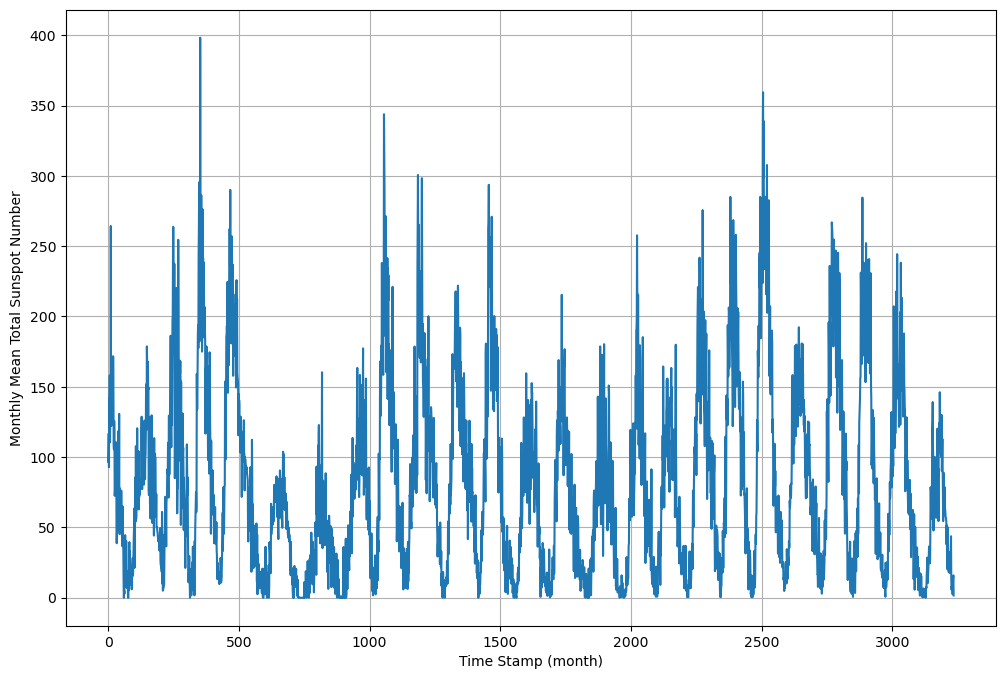

In [6]:
# Plot the total dataset to preview
plot_series(time, series, xlabel='Time Stamp (month)', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [7]:
# Define the split point for training and validation
split_time = 3000

# time and series training set
time_train = time[:split_time]
series_train = series[:split_time]

# time and series validation set
time_val = time[split_time:]
series_val = series[split_time:]

## Prepare Features and Labels

Create a function for windowing the dataset for preprocessing. 

In [8]:
def windowed_dataset(series, window_size, shuffle_buffer, batch_size):
    # Add an axis for the feature
    series = tf.expand_dims(series, axis=-1)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data that shift 1 so that it to overlap with the previous window
    # Set the window_size + 1 since to get the next point as a label.
    dataset = dataset.window(window_size+1, shift=1, stride=1, drop_remainder=True)

    # Flatten the window by putting in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

    # Create a tuple of features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the window
    dataset = dataset.shuffle(shuffle_buffer)

    # Create a batches of windows
    dataset = dataset.batch(batch_size)

    # Optimise the dataset to train
    dataset = dataset.cache().prefetch(1)

    return dataset

Set up a parameter so we don't do hard coding when we want to tweak the parameters when trying with new values. Then use this parameters to create a windowed training set. 

In [9]:
# Parameters
WINDOW_SIZE = 30
SHUFFLE_BUFFER = 1000
BATCH_SIZE = 32

# Create windowed train set
train_set = windowed_dataset(series_train, WINDOW_SIZE, SHUFFLE_BUFFER, BATCH_SIZE)

## Build a Model - CNN-LSTM Model

Let's build a Convolutional Neural Network (CNN) model but combined with Recurrent Neural Network (RNN) using the Long Short-Term Memory (LSTM). Since this is a time series data CNN can help in feature extraction from the input sequence, and the LSTM will capture temporal dependencies in the data. 

1. Sequential data processing: The model is designed to handle sequential input data with a specified window size.
2. Recurrent layers: The LSTM layers are recurrent, maintaining an internal state that can capture information from previous time steps.
3. Time series prediction: The final Dense layer with one unit suggests this model is designed for a regression task, likely predicting a single value.

In [10]:
# Create a model
model = tf.keras.models.Sequential([
    # Decide the input shape
    tf.keras.Input(shape=(WINDOW_SIZE,1)),

    # Use 1D Convolution layer
    # padding = 'causal' since we want the model to only rely on current and future time step. 
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='causal'),

    # Pass it to two LSTM layers. Set the first LSTM to have return_sequences = True 
    # to have output the full sequence of its hidden states for each time step
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),

    # Create two regular densely connected NN layers
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(16),

    # Final layer to output the prediction (single layer)
    tf.keras.layers.Dense(1)
    
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,809 (85.19 KB)

 Trainable params: 21,809 (85.19 KB)

 Non-trainable params: 0 (0.00 B)

Set a init_weights to reset to the initial state of the model to avoid biased result returning. 

In [11]:
# Get initial weights
init_weights = model.get_weights()

## Tune the Learning Rate

We will set the learning rate to be changed according to the epoch so that we can check which learning rate would be suitable to train the model. Selected Adam optimizer since it is a stochastic gradient descent so we can check the lowest loss point by setting different learning rates acorss epochs. 

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule=lambda epoch: 1e-6 *10**(epoch/20))

optimizer = tf.keras.optimizers.Adam()

model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.Huber(),
)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 77.3259 - learning_rate: 1.0000e-06
Epoch 2/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.7019

2025-02-13 15:00:04.469922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 77.3102 - learning_rate: 1.1220e-06
Epoch 3/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.4002

2025-02-13 15:00:05.442277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 77.2927 - learning_rate: 1.2589e-06
Epoch 4/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.6656

2025-02-13 15:00:06.379797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 77.2728 - learning_rate: 1.4125e-06
Epoch 5/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.3589

2025-02-13 15:00:07.317397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 77.2499 - learning_rate: 1.5849e-06
Epoch 6/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 74.1701

2025-02-13 15:00:08.274657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 77.2231 - learning_rate: 1.7783e-06
Epoch 7/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 73.3024

2025-02-13 15:00:09.211190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 77.1908 - learning_rate: 1.9953e-06
Epoch 8/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.5487

2025-02-13 15:00:10.155962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 77.1505 - learning_rate: 2.2387e-06
Epoch 9/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.5008

2025-02-13 15:00:11.095460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 77.1003 - learning_rate: 2.5119e-06
Epoch 10/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.1582

2025-02-13 15:00:12.036717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 77.0396 - learning_rate: 2.8184e-06
Epoch 11/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 73.3747

2025-02-13 15:00:12.977228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 76.9679 - learning_rate: 3.1623e-06
Epoch 12/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 72.2815

2025-02-13 15:00:14.054426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 76.8841 - learning_rate: 3.5481e-06
Epoch 13/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 72.9191

2025-02-13 15:00:15.200271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 76.7871 - learning_rate: 3.9811e-06
Epoch 14/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 72.8113

2025-02-13 15:00:16.164293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 76.6735 - learning_rate: 4.4668e-06
Epoch 15/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 72.6826

2025-02-13 15:00:17.154693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 76.5374 - learning_rate: 5.0119e-06
Epoch 16/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 72.5263

2025-02-13 15:00:18.155886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 76.3714 - learning_rate: 5.6234e-06
Epoch 17/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 72.3352

2025-02-13 15:00:19.144153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 76.1693 - learning_rate: 6.3096e-06
Epoch 18/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 72.0992

2025-02-13 15:00:20.199837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 75.9173 - learning_rate: 7.0795e-06
Epoch 19/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 71.7940

2025-02-13 15:00:21.192302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 75.5897 - learning_rate: 7.9433e-06
Epoch 20/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 71.3986

2025-02-13 15:00:22.182126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 75.1715 - learning_rate: 8.9125e-06
Epoch 21/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 70.9297

2025-02-13 15:00:23.213507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 74.6898 - learning_rate: 1.0000e-05
Epoch 22/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 70.4368

2025-02-13 15:00:24.303756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 74.1903 - learning_rate: 1.1220e-05
Epoch 23/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 69.9207

2025-02-13 15:00:25.296702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 73.6675 - learning_rate: 1.2589e-05
Epoch 24/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 69.3559

2025-02-13 15:00:26.292655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 73.0929 - learning_rate: 1.4125e-05
Epoch 25/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 68.7069

2025-02-13 15:00:27.287660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 72.4285 - learning_rate: 1.5849e-05
Epoch 26/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 67.9413

2025-02-13 15:00:28.268338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 71.6455 - learning_rate: 1.7783e-05
Epoch 27/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 67.0997

2025-02-13 15:00:29.233526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 70.7897 - learning_rate: 1.9953e-05
Epoch 28/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 66.1724

2025-02-13 15:00:30.199265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 69.8235 - learning_rate: 2.2387e-05
Epoch 29/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 65.1141

2025-02-13 15:00:31.164516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 68.7499 - learning_rate: 2.5119e-05
Epoch 30/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 63.9798

2025-02-13 15:00:32.131648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 67.5969 - learning_rate: 2.8184e-05
Epoch 31/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 62.7437

2025-02-13 15:00:33.097184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 66.3273 - learning_rate: 3.1623e-05
Epoch 32/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 61.3883

2025-02-13 15:00:34.063436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 64.9034 - learning_rate: 3.5481e-05
Epoch 33/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 59.8975

2025-02-13 15:00:35.031826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 63.2701 - learning_rate: 3.9811e-05
Epoch 34/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 58.1647

2025-02-13 15:00:36.020758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 61.3332 - learning_rate: 4.4668e-05
Epoch 35/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 56.1858

2025-02-13 15:00:37.010314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 59.0288 - learning_rate: 5.0119e-05
Epoch 36/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 53.7407

2025-02-13 15:00:38.007142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 56.2112 - learning_rate: 5.6234e-05
Epoch 37/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 50.7683

2025-02-13 15:00:38.995595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 52.7956 - learning_rate: 6.3096e-05
Epoch 38/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 47.0523

2025-02-13 15:00:39.995616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 48.7601 - learning_rate: 7.0795e-05
Epoch 39/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 42.8263

2025-02-13 15:00:40.984902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 44.3180 - learning_rate: 7.9433e-05
Epoch 40/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 38.5771

2025-02-13 15:00:41.973909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 39.6513 - learning_rate: 8.9125e-05
Epoch 41/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 34.2979

2025-02-13 15:00:42.942711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 35.0462 - learning_rate: 1.0000e-04
Epoch 42/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 30.3153

2025-02-13 15:00:43.908693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 31.0190 - learning_rate: 1.1220e-04
Epoch 43/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 27.5732

2025-02-13 15:00:44.872685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 27.9751 - learning_rate: 1.2589e-04
Epoch 44/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25.0570

2025-02-13 15:00:45.837939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 25.5404 - learning_rate: 1.4125e-04
Epoch 45/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 23.1026

2025-02-13 15:00:46.812501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 23.6829 - learning_rate: 1.5849e-04
Epoch 46/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.3489

2025-02-13 15:00:47.826790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.3714 - learning_rate: 1.7783e-04
Epoch 47/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.8080

2025-02-13 15:00:48.821425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.9875 - learning_rate: 1.9953e-04
Epoch 48/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.3445

2025-02-13 15:00:49.929025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.9312 - learning_rate: 2.2387e-04
Epoch 49/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.8082

2025-02-13 15:00:50.975803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.7558 - learning_rate: 2.5119e-04
Epoch 50/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.8040

2025-02-13 15:00:51.992755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.1614 - learning_rate: 2.8184e-04
Epoch 51/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.7814

2025-02-13 15:00:53.020650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.0491 - learning_rate: 3.1623e-04
Epoch 52/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.4324

2025-02-13 15:00:54.021925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 18.5963 - learning_rate: 3.5481e-04
Epoch 53/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.9919

2025-02-13 15:00:55.969023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.1171 - learning_rate: 3.9811e-04
Epoch 54/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.9144

2025-02-13 15:00:56.905326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.8329 - learning_rate: 4.4668e-04
Epoch 55/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.1923

2025-02-13 15:00:57.847389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.9235 - learning_rate: 5.0119e-04
Epoch 56/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.1668

2025-02-13 15:00:58.783917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.5844 - learning_rate: 5.6234e-04
Epoch 57/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.7848

2025-02-13 15:00:59.718814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.7747 - learning_rate: 6.3096e-04
Epoch 58/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.6790

2025-02-13 15:01:00.661093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.2866 - learning_rate: 7.0795e-04
Epoch 59/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.2337

2025-02-13 15:01:01.596705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.4151 - learning_rate: 7.9433e-04
Epoch 60/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.8533

2025-02-13 15:01:02.564815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.7447 - learning_rate: 8.9125e-04
Epoch 61/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.9257

2025-02-13 15:01:03.642366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.8722 - learning_rate: 0.0010
Epoch 62/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2747

2025-02-13 15:01:04.728558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.0282 - learning_rate: 0.0011
Epoch 63/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2015

2025-02-13 15:01:05.796597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.7424 - learning_rate: 0.0013
Epoch 64/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.3499

2025-02-13 15:01:06.835423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.3111 - learning_rate: 0.0014
Epoch 65/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.9145

2025-02-13 15:01:07.857100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.2354 - learning_rate: 0.0016
Epoch 66/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.8159

2025-02-13 15:01:08.863157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.6957 - learning_rate: 0.0018
Epoch 67/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.4767

2025-02-13 15:01:09.848689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.1717 - learning_rate: 0.0020
Epoch 68/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.1757

2025-02-13 15:01:10.836545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.7629 - learning_rate: 0.0022
Epoch 69/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.5046

2025-02-13 15:01:11.822848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.4202 - learning_rate: 0.0025
Epoch 70/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.3303

2025-02-13 15:01:12.814406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.5626 - learning_rate: 0.0028
Epoch 71/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.5264

2025-02-13 15:01:13.803390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.8572 - learning_rate: 0.0032
Epoch 72/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.4646

2025-02-13 15:01:14.794096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.6646 - learning_rate: 0.0035
Epoch 73/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.6454

2025-02-13 15:01:15.781931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.5779 - learning_rate: 0.0040
Epoch 74/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.6688

2025-02-13 15:01:16.829483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.4060 - learning_rate: 0.0045
Epoch 75/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.8445

2025-02-13 15:01:17.827457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.8266 - learning_rate: 0.0050
Epoch 76/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.6515

2025-02-13 15:01:18.952397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.4372 - learning_rate: 0.0056
Epoch 77/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.3048

2025-02-13 15:01:19.980697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.7454 - learning_rate: 0.0063
Epoch 78/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.1889

2025-02-13 15:01:21.005412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.8143 - learning_rate: 0.0071
Epoch 79/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2699

2025-02-13 15:01:22.026742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.6590 - learning_rate: 0.0079
Epoch 80/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.1066

2025-02-13 15:01:23.048693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.1251 - learning_rate: 0.0089
Epoch 81/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.6926

2025-02-13 15:01:24.065203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.4808 - learning_rate: 0.0100
Epoch 82/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.7283

2025-02-13 15:01:25.057188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.0871 - learning_rate: 0.0112
Epoch 83/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2654

2025-02-13 15:01:26.053654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.7224 - learning_rate: 0.0126
Epoch 84/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.7772

2025-02-13 15:01:27.045940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.1894 - learning_rate: 0.0141
Epoch 85/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.6102

2025-02-13 15:01:28.041986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.4508 - learning_rate: 0.0158
Epoch 86/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.0478

2025-02-13 15:01:29.029149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.6623 - learning_rate: 0.0178
Epoch 87/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.9571

2025-02-13 15:01:30.018582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.0987 - learning_rate: 0.0200
Epoch 88/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.9578

2025-02-13 15:01:31.007972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.8586 - learning_rate: 0.0224
Epoch 89/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.1715

2025-02-13 15:01:31.995602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.1599 - learning_rate: 0.0251
Epoch 90/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.0311

2025-02-13 15:01:32.987542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.8298 - learning_rate: 0.0282
Epoch 91/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.9314

2025-02-13 15:01:34.089157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.2486 - learning_rate: 0.0316
Epoch 92/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.4868

2025-02-13 15:01:35.109438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.7488 - learning_rate: 0.0355
Epoch 93/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 37.2476

2025-02-13 15:01:36.128011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 36.2322 - learning_rate: 0.0398
Epoch 94/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 35.1733

2025-02-13 15:01:37.173105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 35.3531 - learning_rate: 0.0447
Epoch 95/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 42.1154

2025-02-13 15:01:38.197434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 41.3905 - learning_rate: 0.0501
Epoch 96/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 42.5443

2025-02-13 15:01:39.194921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 37.4210 - learning_rate: 0.0562
Epoch 97/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 48.7485

2025-02-13 15:01:40.185422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 50.7669 - learning_rate: 0.0631
Epoch 98/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 52.0516

2025-02-13 15:01:41.186574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 52.1871 - learning_rate: 0.0708
Epoch 99/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 50.1209

2025-02-13 15:01:42.244059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 51.5505 - learning_rate: 0.0794
Epoch 100/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 50.6930

2025-02-13 15:01:43.285966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 51.7292 - learning_rate: 0.0891


2025-02-13 15:01:44.303019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Now plot the loss to the learning rate and see the result. 

The loss drops down sharply until it passes the learning rate of 1e-6, then flattens out until 1e-4. There is a minor fluctuation during those period but those are not high compared to the sharp increae of loss between the point 1e-4 and 1e-3. 

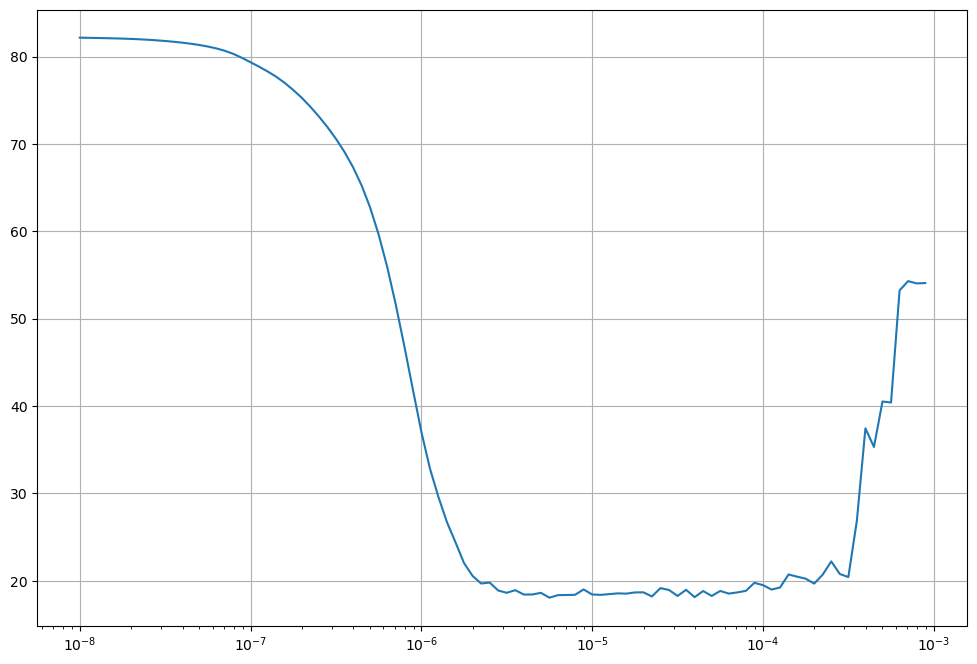

In [13]:
lrs = 1e-8 * 10 ** (np.arange(100) / 20)

plt.figure(figsize=(12,8))

plt.grid(True)

plt.semilogx(lrs, history.history['loss'])


## Train the Model

Based on the model we did earlier let's train our model. First reset the states using keras `clear_session()` and reset the weights to remove any bias during the previous training if the training is to be redone after tweaking the parameters. 

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

I set the learning rate to 1e-4 from the above result. Let's use the learning rate and train the model. 

In [15]:
learning_rate = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.Huber(),
    metrics=['mae']
)

history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 76.8607 - mae: 77.3477
Epoch 2/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 70.6514 - mae: 71.1504

2025-02-13 15:01:49.138056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 73.7001 - mae: 74.1975
Epoch 3/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 66.6312 - mae: 67.1268

2025-02-13 15:01:50.095395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 69.6239 - mae: 70.1198
Epoch 4/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 62.3783 - mae: 62.8697

2025-02-13 15:01:51.060590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 65.4195 - mae: 65.9147
Epoch 5/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 58.4133 - mae: 58.9112

2025-02-13 15:01:52.029342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 61.1035 - mae: 61.6001
Epoch 6/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 53.9848 - mae: 54.4828

2025-02-13 15:01:53.061729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 56.2343 - mae: 56.7311
Epoch 7/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 49.1220 - mae: 49.6172

2025-02-13 15:01:54.136578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 50.7128 - mae: 51.2064
Epoch 8/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 43.7090 - mae: 44.2026

2025-02-13 15:01:55.113572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 45.0717 - mae: 45.5639
Epoch 9/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 38.7820 - mae: 39.2775

2025-02-13 15:01:56.137330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 39.9964 - mae: 40.4902
Epoch 10/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 34.6188 - mae: 35.1120

2025-02-13 15:01:57.161109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 35.4858 - mae: 35.9786
Epoch 11/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 31.1713 - mae: 31.6584

2025-02-13 15:01:58.218307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 31.8579 - mae: 32.3481
Epoch 12/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 28.0889 - mae: 28.5813

2025-02-13 15:01:59.263604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 28.9811 - mae: 29.4725
Epoch 13/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 26.6478 - mae: 27.1408

2025-02-13 15:02:00.346958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 27.3279 - mae: 27.8202
Epoch 14/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25.0259 - mae: 25.5179

2025-02-13 15:02:01.482677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 25.5136 - mae: 26.0046
Epoch 15/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.3488 - mae: 23.8404

2025-02-13 15:02:02.575496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 23.8340 - mae: 24.3253
Epoch 16/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 22.1928 - mae: 22.6859

2025-02-13 15:02:03.667047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 22.5259 - mae: 23.0164
Epoch 17/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 21.1377 - mae: 21.6326

2025-02-13 15:02:04.836374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.3217 - mae: 21.8140
Epoch 18/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.9606 - mae: 20.4523

2025-02-13 15:02:05.970034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.2915 - mae: 20.7815
Epoch 19/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.1069 - mae: 19.6008

2025-02-13 15:02:07.051825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.7228 - mae: 20.2128
Epoch 20/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.3273 - mae: 18.8134

2025-02-13 15:02:08.180591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.0626 - mae: 19.5505
Epoch 21/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.8463 - mae: 18.3396

2025-02-13 15:02:09.234343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.6719 - mae: 19.1621
Epoch 22/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.5260 - mae: 18.0162

2025-02-13 15:02:10.290567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.2843 - mae: 18.7728
Epoch 23/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.2085 - mae: 17.6969

2025-02-13 15:02:11.359213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.8773 - mae: 18.3648
Epoch 24/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.4304 - mae: 17.9134

2025-02-13 15:02:12.400383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.7421 - mae: 18.2291
Epoch 25/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.9558 - mae: 17.4479

2025-02-13 15:02:13.424471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.4819 - mae: 17.9706
Epoch 26/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.9858 - mae: 17.4743

2025-02-13 15:02:14.434969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.3665 - mae: 17.8529
Epoch 27/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.2297 - mae: 17.7192

2025-02-13 15:02:15.441463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.3367 - mae: 17.8245
Epoch 28/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.2860 - mae: 17.7741

2025-02-13 15:02:16.428403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.2327 - mae: 17.7198
Epoch 29/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.0952 - mae: 17.5831

2025-02-13 15:02:17.405999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.1034 - mae: 17.5904
Epoch 30/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.7342 - mae: 17.2224

2025-02-13 15:02:18.458030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.8703 - mae: 17.3574
Epoch 31/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.8137 - mae: 17.3003

2025-02-13 15:02:19.552972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.9020 - mae: 17.3886
Epoch 32/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.0005 - mae: 17.4918

2025-02-13 15:02:20.583554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.8769 - mae: 17.3659
Epoch 33/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.7628 - mae: 17.2525

2025-02-13 15:02:21.622409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.7013 - mae: 17.1898
Epoch 34/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6963 - mae: 17.1834

2025-02-13 15:02:22.634005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.6667 - mae: 17.1542
Epoch 35/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6517 - mae: 17.1398

2025-02-13 15:02:23.690283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.5890 - mae: 17.0764
Epoch 36/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.5812 - mae: 17.0685

2025-02-13 15:02:24.724783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.5525 - mae: 17.0386
Epoch 37/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.4721 - mae: 16.9558

2025-02-13 15:02:25.756841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.4881 - mae: 16.9736
Epoch 38/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6475 - mae: 17.1317

2025-02-13 15:02:26.774715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.4982 - mae: 16.9831
Epoch 39/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.5616 - mae: 17.0474

2025-02-13 15:02:27.856268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.4488 - mae: 16.9354
Epoch 40/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.5685 - mae: 17.0566

2025-02-13 15:02:28.858707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.4959 - mae: 16.9822
Epoch 41/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.4201 - mae: 16.9080

2025-02-13 15:02:29.847602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.3364 - mae: 16.8243
Epoch 42/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 16.5074 - mae: 16.9938

2025-02-13 15:02:30.873641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.3366 - mae: 16.8241
Epoch 43/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.2630 - mae: 16.7501

2025-02-13 15:02:31.931684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.2395 - mae: 16.7268
Epoch 44/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.1652 - mae: 16.6553

2025-02-13 15:02:32.944371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.2193 - mae: 16.7061
Epoch 45/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.0533 - mae: 16.5400

2025-02-13 15:02:33.943723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.1536 - mae: 16.6393
Epoch 46/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.0838 - mae: 16.5679

2025-02-13 15:02:35.014120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.1616 - mae: 16.6476
Epoch 47/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.0638 - mae: 16.5556

2025-02-13 15:02:36.120378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.1200 - mae: 16.6084
Epoch 48/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.1023 - mae: 16.5887

2025-02-13 15:02:37.150059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.2103 - mae: 16.6974
Epoch 49/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.8792 - mae: 16.3677

2025-02-13 15:02:38.184640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.1098 - mae: 16.5962
Epoch 50/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.9136 - mae: 16.3972

2025-02-13 15:02:39.185628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.2154 - mae: 16.7002
Epoch 51/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.0936 - mae: 16.5805

2025-02-13 15:02:40.166294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.1343 - mae: 16.6202
Epoch 52/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.0761 - mae: 16.5623

2025-02-13 15:02:41.136088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.1455 - mae: 16.6316
Epoch 53/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.0337 - mae: 16.5219

2025-02-13 15:02:42.109652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.1043 - mae: 16.5904
Epoch 54/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.0939 - mae: 16.5820

2025-02-13 15:02:43.083373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.1015 - mae: 16.5882
Epoch 55/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.0849 - mae: 16.5767

2025-02-13 15:02:44.054362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.1458 - mae: 16.6345
Epoch 56/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.2035 - mae: 16.6927

2025-02-13 15:02:45.026134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.1308 - mae: 16.6174
Epoch 57/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.9742 - mae: 16.4631

2025-02-13 15:02:45.994835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.9831 - mae: 16.4682
Epoch 58/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.9902 - mae: 16.4782

2025-02-13 15:02:47.001898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.9710 - mae: 16.4575
Epoch 59/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.8792 - mae: 16.3696

2025-02-13 15:02:47.997671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.9220 - mae: 16.4077
Epoch 60/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.9768 - mae: 16.4652

2025-02-13 15:02:49.114951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.9320 - mae: 16.4183
Epoch 61/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.8096 - mae: 16.3008

2025-02-13 15:02:50.145172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.9092 - mae: 16.3966
Epoch 62/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.9325 - mae: 16.4208

2025-02-13 15:02:51.171902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.9607 - mae: 16.4466
Epoch 63/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.0161 - mae: 16.5061

2025-02-13 15:02:52.184643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.9625 - mae: 16.4487
Epoch 64/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.8650 - mae: 16.3522

2025-02-13 15:02:53.176232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.8714 - mae: 16.3566
Epoch 65/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.7591 - mae: 16.2488

2025-02-13 15:02:54.146715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.8170 - mae: 16.3030
Epoch 66/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.9147 - mae: 16.4014

2025-02-13 15:02:55.120348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.8500 - mae: 16.3361
Epoch 67/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.7636 - mae: 16.2517

2025-02-13 15:02:56.105789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.7994 - mae: 16.2846
Epoch 68/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.6661 - mae: 16.1536

2025-02-13 15:02:57.081766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.7176 - mae: 16.2019
Epoch 69/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.7011 - mae: 16.1895

2025-02-13 15:02:58.056433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.7147 - mae: 16.2000
Epoch 70/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.8704 - mae: 16.3548

2025-02-13 15:02:59.030315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.8012 - mae: 16.2847
Epoch 71/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.8385 - mae: 16.3217

2025-02-13 15:03:00.000564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.7290 - mae: 16.2131
Epoch 72/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.7165 - mae: 16.2046

2025-02-13 15:03:00.994883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.6894 - mae: 16.1734
Epoch 73/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.8013 - mae: 16.2869

2025-02-13 15:03:01.990442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.7191 - mae: 16.2017
Epoch 74/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.5353 - mae: 16.0217

2025-02-13 15:03:02.991021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.7081 - mae: 16.1933
Epoch 75/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.6380 - mae: 16.1259

2025-02-13 15:03:04.002052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.7417 - mae: 16.2278
Epoch 76/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.6580 - mae: 16.1421

2025-02-13 15:03:05.088314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.6577 - mae: 16.1418
Epoch 77/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.5711 - mae: 16.0543

2025-02-13 15:03:06.084311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.6223 - mae: 16.1075
Epoch 78/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.6237 - mae: 16.1081

2025-02-13 15:03:07.087234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.6193 - mae: 16.1036
Epoch 79/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.6416 - mae: 16.1298

2025-02-13 15:03:08.092402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.6045 - mae: 16.0900
Epoch 80/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.5434 - mae: 16.0272

2025-02-13 15:03:09.087629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.6286 - mae: 16.1119
Epoch 81/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.4507 - mae: 15.9366

2025-02-13 15:03:10.083367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.5994 - mae: 16.0837
Epoch 82/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.6553 - mae: 16.1392

2025-02-13 15:03:11.058838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.6896 - mae: 16.1753
Epoch 83/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.5021 - mae: 15.9855

2025-02-13 15:03:12.027659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.5864 - mae: 16.0711
Epoch 84/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.4854 - mae: 15.9675

2025-02-13 15:03:13.001708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.5810 - mae: 16.0653
Epoch 85/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.5691 - mae: 16.0539

2025-02-13 15:03:13.987637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.5801 - mae: 16.0652
Epoch 86/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.3728 - mae: 15.8595

2025-02-13 15:03:14.960043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.4994 - mae: 15.9841
Epoch 87/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.4999 - mae: 15.9832

2025-02-13 15:03:15.931225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.5377 - mae: 16.0217
Epoch 88/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.4296 - mae: 15.9142

2025-02-13 15:03:16.903954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.5002 - mae: 15.9844
Epoch 89/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.4153 - mae: 15.8968

2025-02-13 15:03:17.874193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.4333 - mae: 15.9171
Epoch 90/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.3465 - mae: 15.8325

2025-02-13 15:03:18.871156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.4574 - mae: 15.9430
Epoch 91/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.3709 - mae: 15.8558

2025-02-13 15:03:19.870458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.4025 - mae: 15.8863
Epoch 92/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.2800 - mae: 15.7633

2025-02-13 15:03:20.868283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.4079 - mae: 15.8906
Epoch 93/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.3125 - mae: 15.7983

2025-02-13 15:03:21.867985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.4655 - mae: 15.9501
Epoch 94/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.2437 - mae: 15.7214

2025-02-13 15:03:22.875756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.3611 - mae: 15.8435
Epoch 95/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.2819 - mae: 15.7666

2025-02-13 15:03:23.977212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.3776 - mae: 15.8629
Epoch 96/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.3509 - mae: 15.8380

2025-02-13 15:03:24.973097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.3995 - mae: 15.8859
Epoch 97/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.2561 - mae: 15.7437

2025-02-13 15:03:25.983323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.4211 - mae: 15.9085
Epoch 98/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.2586 - mae: 15.7442

2025-02-13 15:03:26.981578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.3088 - mae: 15.7943
Epoch 99/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.2685 - mae: 15.7544

2025-02-13 15:03:27.977425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.3586 - mae: 15.8436
Epoch 100/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.2149 - mae: 15.7013

2025-02-13 15:03:28.976896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15.3049 - mae: 15.7900


2025-02-13 15:03:29.947587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Now let's plot the Mean Absolute Error (MAE) and the loss to see the tendency.

There is a similar pattern of decrease on both MAE and loss but MAE being slightly above loss. If we zoom in a little closer to we can see the mae and loss are both steadily decreasing. 

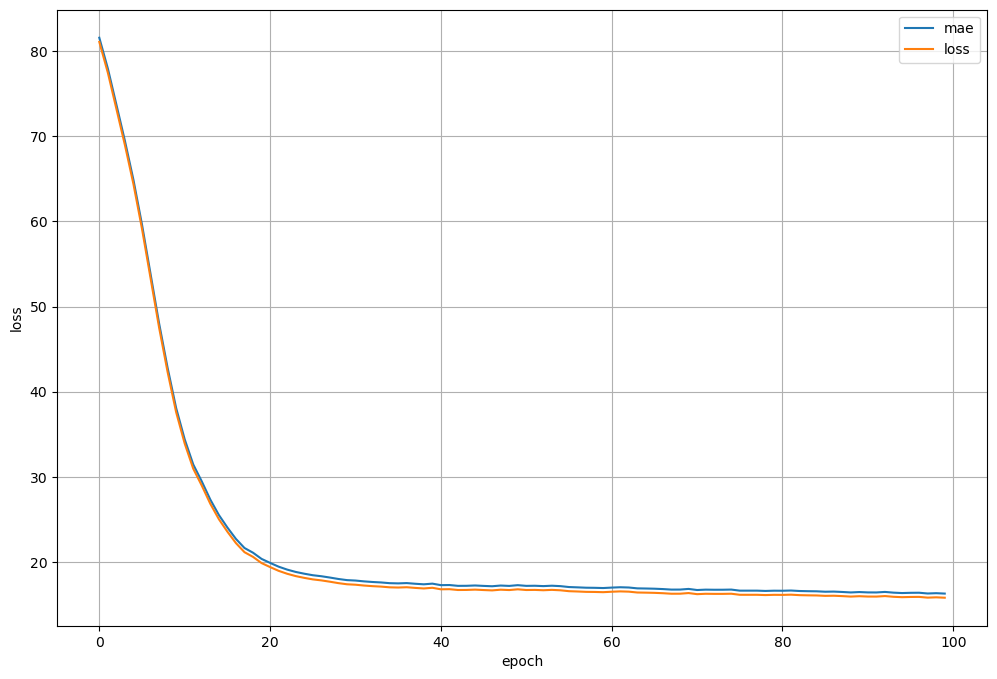

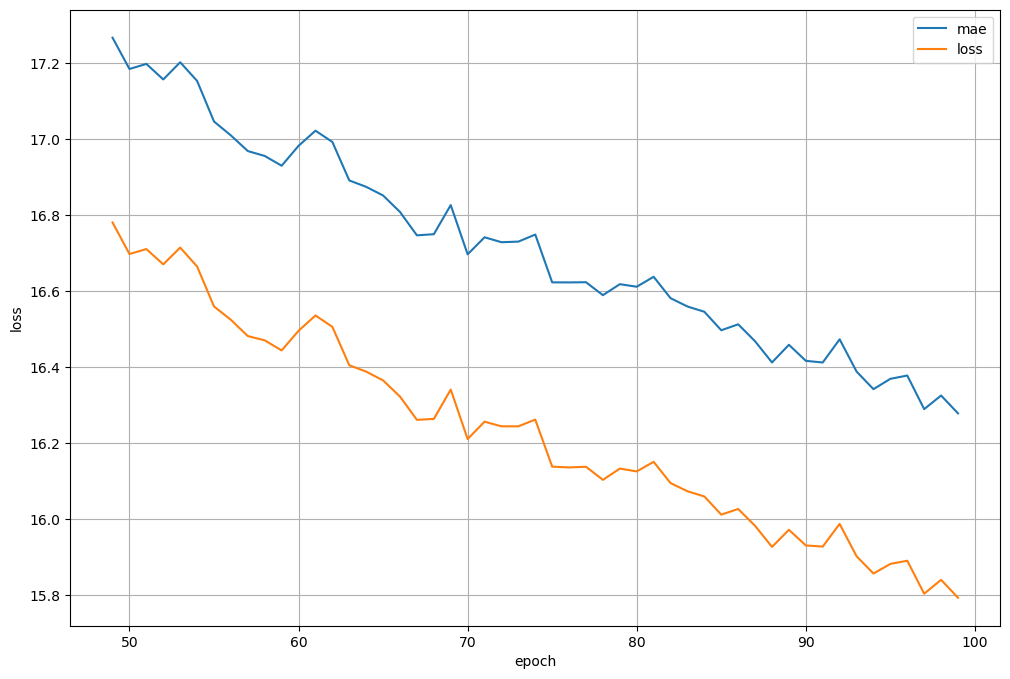

In [16]:
# Save mae and loss from history
mae = history.history['mae']
loss = history.history['loss']

# Get the number of epochs
epochs = range(len(loss))

# Plot mae and loss
plot_series(x=epochs, y=(mae, loss), xlabel='epoch', ylabel='loss', legend=['mae', 'loss'])

# Zoom-in parameters
zoom_split = int(epochs[-1]*0.5)
epoch_zoomed = epochs[zoom_split:]
mae_zoomed = mae[zoom_split:]
loss_zoomed = loss[zoom_split:]

# Plot mae and loss zoomed in per zoom-in params
plot_series(x=epoch_zoomed, y=(mae_zoomed, loss_zoomed), xlabel='epoch', ylabel='loss', legend=['mae', 'loss'])

## Model Prediction

Now let's see if our model is working well. First, we will create a function that forecasts the data. 

In [17]:
def model_forecast(model, series, window_size, batch_size):
    # Add axis at the end of the dimension 
    series = tf.expand_dims(series, axis=-1)

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data that shift 1 so that it to overlap with the previous window
    dataset = dataset.window(window_size, shift=1, stride=1, drop_remainder=True)

    # Flatten the window by putting in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))

    # Create a batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions
    forecast = model.predict(dataset, verbose=2)

    return forecast

Now check with the validation data to see how well our model is working. 

Looks pretty nice but there are some parts that are not aligned to the validation data. Especially, time steps between 3100 and 3150 we can see the prediction model is almost flattening out while the validation data has some fluctuations. But as for the first model this is not too bad. 

8/8 - 1s - 64ms/step


2025-02-13 15:03:30.828800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


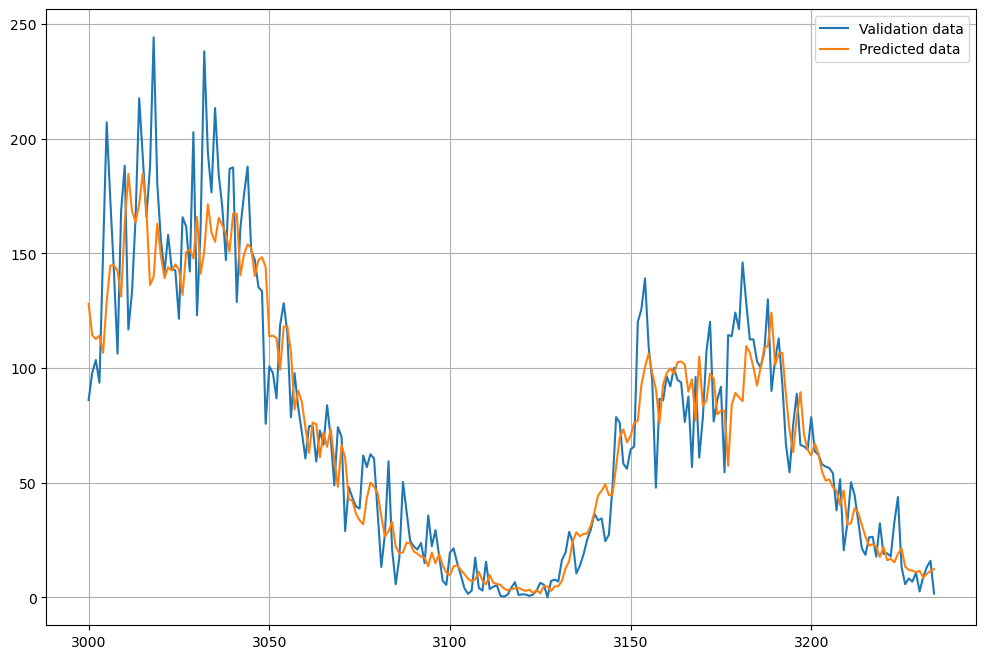

In [18]:
forecast_series = series[split_time-WINDOW_SIZE:-1]

forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

results = forecast.squeeze()

plot_series(time_val, (series_val, results), legend=('Validation data', 'Predicted data'))

Let's create a function that computes the Mean Squared Error (MSE) and the Mean Absolute Error (MAE) to get each mse and mae of our model. 

In [19]:
# Function to return mse and mae
def compute_metrics(series_val, results):
    mse = tf.keras.losses.MSE(series_val, results)
    mae = tf.keras.losses.MAE(series_val, results)
    return mse.numpy(), mae.numpy()

In [20]:
# Implement our validation data and the model result to get the mse and mae
mse, mae = compute_metrics(series_val, results)

# Print the mse and mae
print(f"MSE: {mse}, MAE: {mae}")

MSE: 478.865234375, MAE: 14.734383583068848


In [21]:
# Save metrics into a dictionary
metrics_dict = {
    "mse": float(mse),
    "mae": float(mae)
}
# Save the metrics in a binary file 
with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)

## Predict the Future

Let's predict how the number of sunspots are going to be in the near future. 

In [22]:
forecast_period = 100
forecast = []

# Extract the last WINDOW_SIZE elements as input for prediction
last_sequence = series[-WINDOW_SIZE:]

for _ in range(forecast_period):
    current_sequence = last_sequence.reshape((1, WINDOW_SIZE, 1))
    next_prediction = model.predict(current_sequence)[0][0]
    forecast.append(next_prediction)
    last_sequence = np.append(last_sequence[1:], next_prediction)
forecast

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

[7.3037553,
 8.421016,
 8.775338,
 8.266864,
 8.45053,
 8.879353,
 9.26508,
 9.7727995,
 10.306835,
 10.992789,
 11.864126,
 12.936922,
 14.370239,
 15.819261,
 18.336575,
 21.253904,
 25.871244,
 31.886137,
 40.106747,
 50.424004,
 58.76583,
 65.25801,
 70.24566,
 73.78083,
 76.927055,
 79.22753,
 81.79609,
 83.62441,
 84.88136,
 85.70943,
 85.28158,
 84.72277,
 84.43593,
 84.397705,
 84.40292,
 84.43223,
 84.44961,
 84.364944,
 84.15051,
 83.94051,
 83.99722,
 84.61368,
 86.34951,
 92.358055,
 103.77114,
 108.87158,
 109.51176,
 107.96851,
 106.790184,
 105.87502,
 104.704765,
 103.59466,
 102.86379,
 102.34585,
 101.88651,
 101.28904,
 100.52186,
 99.691765,
 98.83153,
 98.07433,
 97.50782,
 96.948784,
 96.26871,
 95.45064,
 94.51953,
 93.478836,
 92.3188,
 91.02127,
 89.58755,
 88.11765,
 86.73593,
 85.26328,
 83.187225,
 78.70158,
 72.86216,
 67.63146,
 63.438755,
 59.81044,
 56.212746,
 52.568104,
 48.931038,
 45.233063,
 41.479996,
 37.8531,
 34.62795,
 31.96295,
 29.829737,
 28

Let's plot the validation data and forecasted data to see how the future tendency looks like. 



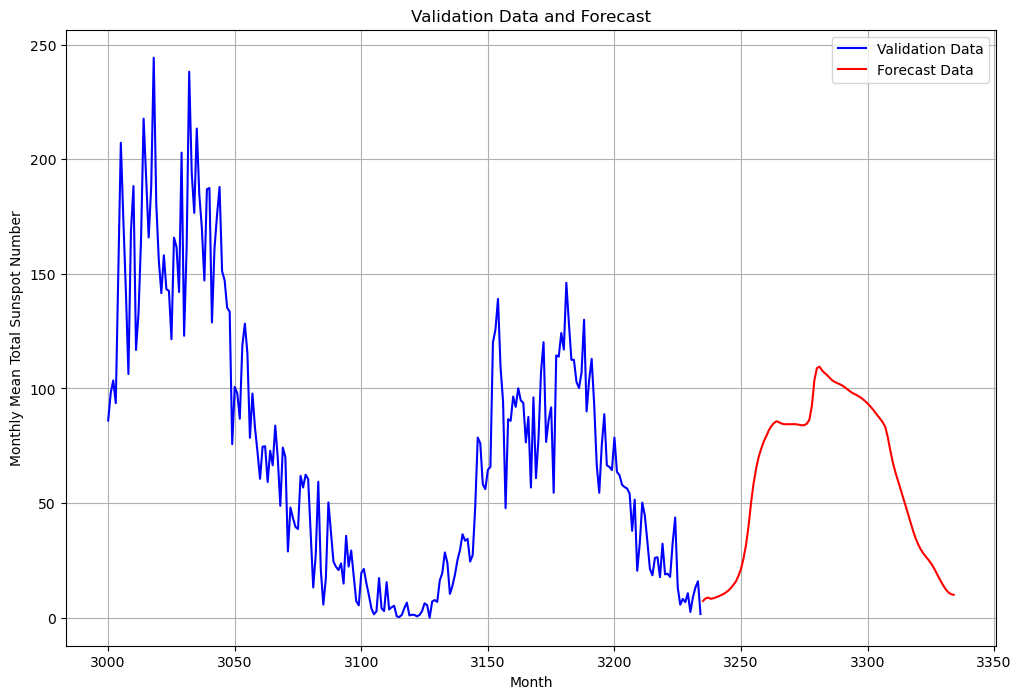

In [23]:
# Create a list of future time step starting from +1 after the validation time step
forecast_time = [x + time_val[-1] + 1 for x in range(100)]

plt.figure(figsize=(12, 8))

# Plot validation data
plt.plot(time_val, series_val, color='blue', label='Validation Data')

# Plot forecasted data
plt.plot(forecast_time, forecast, color='red', label='Forecast Data')

plt.legend()
plt.grid(True)
plt.xlabel('Month')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Validation Data and Forecast')
plt.show()


From the forecasted data, we don't get to see the high fluctuations as we have seen on the total series dataset, but we can still get the smoothen version of how the direction of the number of sunspots will be in the near future. 

Considering the solar cycle is a periodic 11-year change in the Sun's activity measured in terms of variations in the number of observed sunspots on the Sun's surface, scientists predicted during the year 2024 and 2025 to be the peak time of sun's activity. Since the last date on the validation data is for July 2018 on the time step 3234, the peak we can see on the forecasted data is not the best but fairly accurate. Time step 3306 to 3318 is presented the 2024 and 2025. Our forecasted data is plot to have a peak in the middle between 3250 and 3300 meaning the forecasted plot would be better to be moved slightly to the right. But still the forecasted data is on its right track. 

## Different Model - Simple RNN

Let's try a simple RNN model and see how that could bring a better result. 

I will build a model that only has two layers of SimpleRNN and a Dense layer. Then training the model, checking the loss tendency and predicting the model steps are the same as before.  


In [24]:
# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
optimizer = tf.keras.optimizers.Adam()

model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.Huber(),
    metrics=['mae']
)

history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 69.1531 - mae: 69.6484
Epoch 2/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 52.8434 - mae: 53.3391

2025-02-13 15:03:42.486414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 58.0004 - mae: 58.4952
Epoch 3/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 47.0677 - mae: 47.5628

2025-02-13 15:03:44.810734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 51.2553 - mae: 51.7490
Epoch 4/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 40.2738 - mae: 40.7715

2025-02-13 15:03:47.355364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 45.3671 - mae: 45.8608
Epoch 5/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 36.5618 - mae: 37.0556

2025-02-13 15:03:50.120489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 40.8544 - mae: 41.3462
Epoch 6/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 33.5046 - mae: 33.9984

2025-02-13 15:03:52.827654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 36.8821 - mae: 37.3745
Epoch 7/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 30.8839 - mae: 31.3834

2025-02-13 15:03:55.487902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 33.8011 - mae: 34.2930
Epoch 8/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 28.4663 - mae: 28.9651

2025-02-13 15:03:58.009993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 31.5177 - mae: 32.0102
Epoch 9/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 26.9915 - mae: 27.4887

2025-02-13 15:04:00.934395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 29.6589 - mae: 30.1516
Epoch 10/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 25.8428 - mae: 26.3414

2025-02-13 15:04:03.715527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 28.1550 - mae: 28.6474
Epoch 11/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 24.8376 - mae: 25.3343

2025-02-13 15:04:06.445971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 26.8399 - mae: 27.3306
Epoch 12/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 23.7229 - mae: 24.2194

2025-02-13 15:04:09.357052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 25.8735 - mae: 26.3628
Epoch 13/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 22.9048 - mae: 23.3978

2025-02-13 15:04:12.067031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 24.9087 - mae: 25.4008
Epoch 14/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 22.3598 - mae: 22.8576

2025-02-13 15:04:14.769997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 24.0356 - mae: 24.5273
Epoch 15/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 21.4404 - mae: 21.9290

2025-02-13 15:04:17.484574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 23.2070 - mae: 23.6962
Epoch 16/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 20.8200 - mae: 21.3144

2025-02-13 15:04:20.169272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 22.5357 - mae: 23.0258
Epoch 17/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 20.2204 - mae: 20.7134

2025-02-13 15:04:22.838569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 21.8543 - mae: 22.3437
Epoch 18/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 19.9553 - mae: 20.4530

2025-02-13 15:04:25.758773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 21.3212 - mae: 21.8109
Epoch 19/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 18.8721 - mae: 19.3655

2025-02-13 15:04:28.469654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 20.8546 - mae: 21.3449
Epoch 20/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 18.5654 - mae: 19.0517

2025-02-13 15:04:31.164161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 20.2351 - mae: 20.7232
Epoch 21/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 18.2638 - mae: 18.7544

2025-02-13 15:04:33.871969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 19.7605 - mae: 20.2482
Epoch 22/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 17.6728 - mae: 18.1658

2025-02-13 15:04:36.567222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 19.3003 - mae: 19.7887
Epoch 23/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 16.4189 - mae: 16.8991

2025-02-13 15:04:39.221746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 18.8464 - mae: 19.3320
Epoch 24/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 16.4490 - mae: 16.9339

2025-02-13 15:04:41.846997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 18.5022 - mae: 18.9878
Epoch 25/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 15.9977 - mae: 16.4790

2025-02-13 15:04:44.721484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 18.1739 - mae: 18.6601
Epoch 26/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 16.3028 - mae: 16.7913

2025-02-13 15:04:47.433245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 18.0583 - mae: 18.5447
Epoch 27/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 15.5961 - mae: 16.0807

2025-02-13 15:04:50.037964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 17.6786 - mae: 18.1673
Epoch 28/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 15.7568 - mae: 16.2492

2025-02-13 15:04:52.701602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 17.5792 - mae: 18.0676
Epoch 29/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 15.1763 - mae: 15.6616

2025-02-13 15:04:55.200738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 17.2266 - mae: 17.7122
Epoch 30/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 15.6921 - mae: 16.1846

2025-02-13 15:04:57.712559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 17.0645 - mae: 17.5514
Epoch 31/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 15.2399 - mae: 15.7258

2025-02-13 15:05:00.212780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 17.0517 - mae: 17.5387
Epoch 32/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 15.4465 - mae: 15.9366

2025-02-13 15:05:02.708405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 16.8660 - mae: 17.3522
Epoch 33/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 14.6924 - mae: 15.1656

2025-02-13 15:05:05.401639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 16.8224 - mae: 17.3064
Epoch 34/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 14.8301 - mae: 15.3153

2025-02-13 15:05:07.988769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 16.7431 - mae: 17.2289
Epoch 35/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 15.0306 - mae: 15.5205

2025-02-13 15:05:10.504604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 16.4268 - mae: 16.9120
Epoch 36/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 14.7775 - mae: 15.2637

2025-02-13 15:05:12.996688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 16.3245 - mae: 16.8091
Epoch 37/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 14.0577 - mae: 14.5442

2025-02-13 15:05:15.655973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 16.1233 - mae: 16.6107
Epoch 38/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 13.8669 - mae: 14.3535

2025-02-13 15:05:18.637425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 16.0524 - mae: 16.5366
Epoch 39/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 13.9002 - mae: 14.3902

2025-02-13 15:05:21.366374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 15.9693 - mae: 16.4557
Epoch 40/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 14.0798 - mae: 14.5640

2025-02-13 15:05:24.054413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 16.0334 - mae: 16.5193
Epoch 41/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 13.4866 - mae: 13.9724

2025-02-13 15:05:26.835102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 15.6379 - mae: 16.1210
Epoch 42/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 13.9106 - mae: 14.3930

2025-02-13 15:05:29.677274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 15.7876 - mae: 16.2706
Epoch 43/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 13.9005 - mae: 14.3811

2025-02-13 15:05:32.426614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 15.4921 - mae: 15.9747
Epoch 44/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 13.4628 - mae: 13.9403

2025-02-13 15:05:35.046040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 15.4082 - mae: 15.8923
Epoch 45/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 13.2479 - mae: 13.7290

2025-02-13 15:05:37.707418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 15.2589 - mae: 15.7417
Epoch 46/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 13.2590 - mae: 13.7404

2025-02-13 15:05:40.294379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 15.1849 - mae: 15.6680
Epoch 47/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 13.4633 - mae: 13.9425

2025-02-13 15:05:42.960823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 15.2933 - mae: 15.7789
Epoch 48/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 12.9971 - mae: 13.4735

2025-02-13 15:05:45.536851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 14.9714 - mae: 15.4551
Epoch 49/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 13.1927 - mae: 13.6762

2025-02-13 15:05:48.142509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 14.9885 - mae: 15.4731
Epoch 50/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 13.4884 - mae: 13.9718

2025-02-13 15:05:51.146209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 14.9622 - mae: 15.4457
Epoch 51/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 12.8946 - mae: 13.3830

2025-02-13 15:05:54.102670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 14.7836 - mae: 15.2678
Epoch 52/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 13.4443 - mae: 13.9417

2025-02-13 15:05:56.808266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 14.8608 - mae: 15.3479
Epoch 53/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 12.7033 - mae: 13.1891

2025-02-13 15:05:59.404440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 14.4924 - mae: 14.9748
Epoch 54/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 12.8203 - mae: 13.3002

2025-02-13 15:06:02.086039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 14.4221 - mae: 14.9045
Epoch 55/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 12.5541 - mae: 13.0340

2025-02-13 15:06:04.659786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 14.3223 - mae: 14.8043
Epoch 56/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.6430 - mae: 13.1300

2025-02-13 15:06:07.224274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 14.2611 - mae: 14.7439
Epoch 57/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 13.1344 - mae: 13.6148

2025-02-13 15:06:09.748741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 14.2151 - mae: 14.6961
Epoch 58/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.5852 - mae: 13.0668

2025-02-13 15:06:12.235976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 14.2518 - mae: 14.7325
Epoch 59/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.7261 - mae: 13.2050

2025-02-13 15:06:14.825720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 14.3826 - mae: 14.8641
Epoch 60/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 13.1690 - mae: 13.6582

2025-02-13 15:06:17.310269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 14.1385 - mae: 14.6204
Epoch 61/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 11.8816 - mae: 12.3473

2025-02-13 15:06:19.860128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 13.9407 - mae: 14.4166
Epoch 62/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 12.7228 - mae: 13.1976

2025-02-13 15:06:22.626360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 13.9252 - mae: 14.4036
Epoch 63/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.6075 - mae: 13.0862

2025-02-13 15:06:25.143912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 13.7480 - mae: 14.2285
Epoch 64/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.5737 - mae: 13.0658

2025-02-13 15:06:27.630702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 13.7613 - mae: 14.2438
Epoch 65/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.6486 - mae: 13.1238

2025-02-13 15:06:30.130321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 13.7553 - mae: 14.2347
Epoch 66/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 12.2647 - mae: 12.7532

2025-02-13 15:06:32.612619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 13.5228 - mae: 14.0040
Epoch 67/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 11.6498 - mae: 12.1296

2025-02-13 15:06:35.283518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 13.5593 - mae: 14.0380
Epoch 68/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 13.0341 - mae: 13.5098

2025-02-13 15:06:37.842084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 13.7655 - mae: 14.2451
Epoch 69/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.4660 - mae: 12.9545

2025-02-13 15:06:40.385335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 13.5344 - mae: 14.0191
Epoch 70/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.1909 - mae: 12.6724

2025-02-13 15:06:42.868596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 13.3029 - mae: 13.7801
Epoch 71/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.8431 - mae: 12.3190

2025-02-13 15:06:45.354997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 13.2021 - mae: 13.6802
Epoch 72/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 11.7917 - mae: 12.2669

2025-02-13 15:06:47.875375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 13.3401 - mae: 13.8164
Epoch 73/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.1098 - mae: 12.5859

2025-02-13 15:06:50.377806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 13.2230 - mae: 13.7021
Epoch 74/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 11.4355 - mae: 11.9167

2025-02-13 15:06:53.103812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 13.0018 - mae: 13.4803
Epoch 75/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.0937 - mae: 12.5733

2025-02-13 15:06:55.675687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.8632 - mae: 13.3387
Epoch 76/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.0421 - mae: 11.5146

2025-02-13 15:06:58.166312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.6051 - mae: 13.0818
Epoch 77/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.0385 - mae: 11.5130

2025-02-13 15:07:00.662918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.4665 - mae: 12.9414
Epoch 78/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.6489 - mae: 12.1305

2025-02-13 15:07:03.154377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.3930 - mae: 12.8687
Epoch 79/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.6098 - mae: 12.0871

2025-02-13 15:07:05.644832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 12.4311 - mae: 12.9042
Epoch 80/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 11.1004 - mae: 11.5769

2025-02-13 15:07:08.182257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 12.2767 - mae: 12.7522
Epoch 81/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 10.9216 - mae: 11.4018

2025-02-13 15:07:10.859805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 12.3176 - mae: 12.7939
Epoch 82/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.1347 - mae: 11.6215

2025-02-13 15:07:13.451769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.1104 - mae: 12.5882
Epoch 83/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.2715 - mae: 11.7499

2025-02-13 15:07:15.953876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 12.2759 - mae: 12.7548
Epoch 84/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10.8589 - mae: 11.3296

2025-02-13 15:07:18.448658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.9474 - mae: 12.4229
Epoch 85/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 10.9626 - mae: 11.4398

2025-02-13 15:07:20.944860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 12.0753 - mae: 12.5517
Epoch 86/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 10.5111 - mae: 10.9778

2025-02-13 15:07:23.516573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 11.7843 - mae: 12.2583
Epoch 87/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 10.5463 - mae: 11.0200

2025-02-13 15:07:26.144624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 11.7865 - mae: 12.2620
Epoch 88/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 10.9552 - mae: 11.4450

2025-02-13 15:07:28.711051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 12.0757 - mae: 12.5560
Epoch 89/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10.8429 - mae: 11.3319

2025-02-13 15:07:31.227728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.8479 - mae: 12.3277
Epoch 90/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10.8830 - mae: 11.3521

2025-02-13 15:07:33.718154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.6658 - mae: 12.1383
Epoch 91/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10.6150 - mae: 11.0794

2025-02-13 15:07:36.204547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.5404 - mae: 12.0116
Epoch 92/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10.6945 - mae: 11.1610

2025-02-13 15:07:38.688170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 11.5019 - mae: 11.9732
Epoch 93/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 10.4077 - mae: 10.8981

2025-02-13 15:07:41.295484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 11.3937 - mae: 11.8697
Epoch 94/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 10.1403 - mae: 10.6151

2025-02-13 15:07:43.995099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 11.2759 - mae: 11.7465
Epoch 95/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10.0310 - mae: 10.4927

2025-02-13 15:07:46.567294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 11.0749 - mae: 11.5433
Epoch 96/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 10.5445 - mae: 11.0126

2025-02-13 15:07:49.054383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 11.4831 - mae: 11.9564
Epoch 97/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 10.3770 - mae: 10.8534

2025-02-13 15:07:51.557893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 11.2367 - mae: 11.7098
Epoch 98/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 10.6989 - mae: 11.1577

2025-02-13 15:07:54.178256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 11.2392 - mae: 11.7117
Epoch 99/100
 5/93 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 9.4157 - mae: 9.8693

2025-02-13 15:07:56.794651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 10.8833 - mae: 11.3489
Epoch 100/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.6121 - mae: 10.0802

2025-02-13 15:07:59.529927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 10.8224 - mae: 11.2922


2025-02-13 15:08:02.200839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


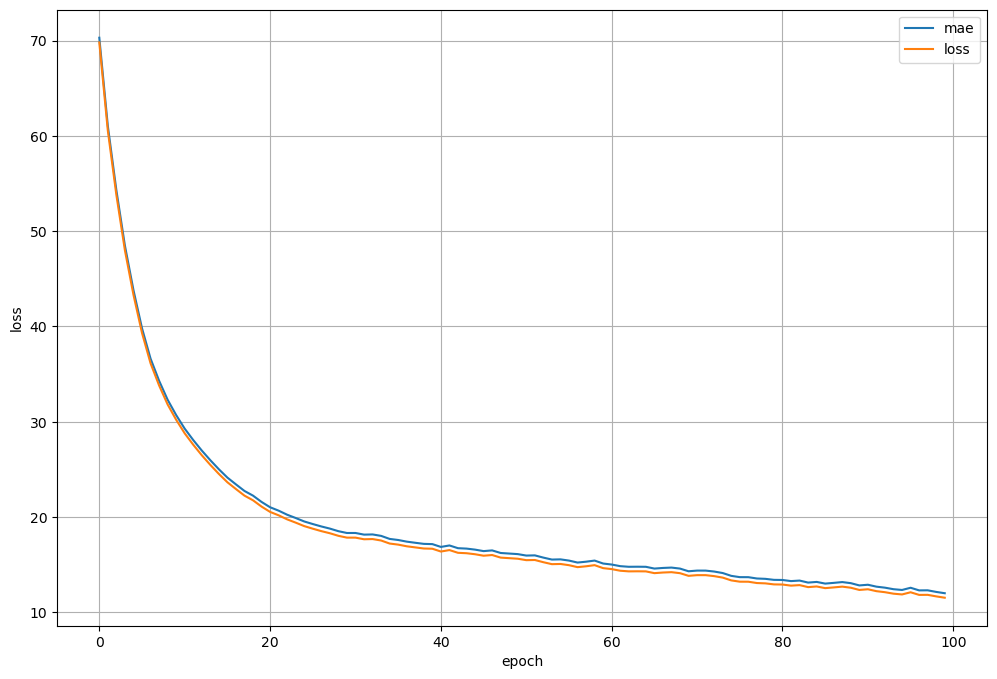

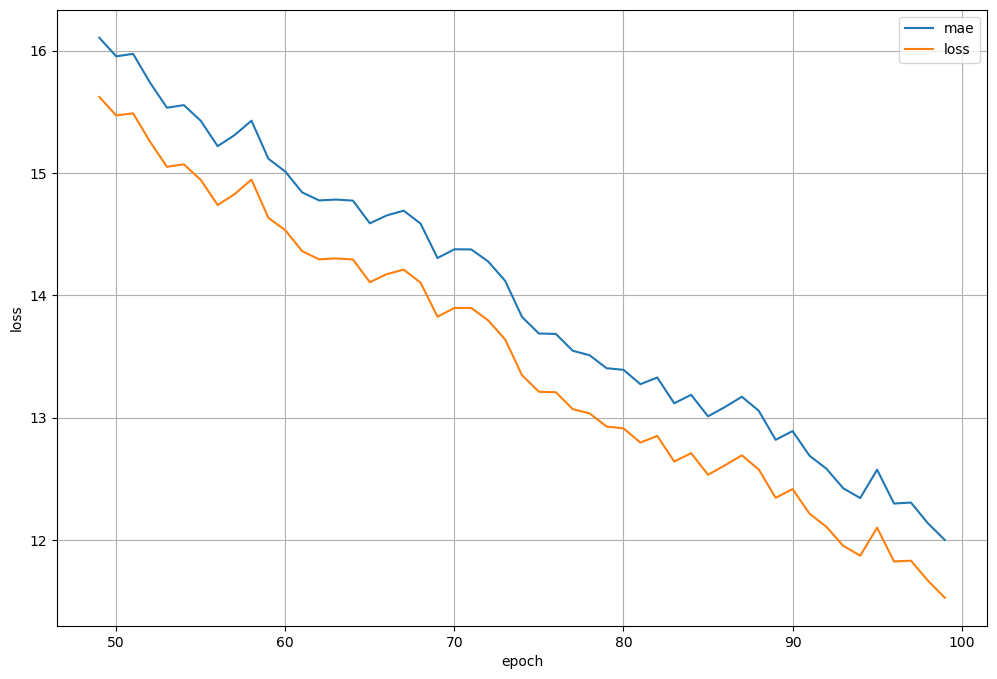

In [27]:
# Save mae and loss from history
mae = history.history['mae']
loss = history.history['loss']

# Get the number of epochs
epochs = range(len(loss))

# Plot mae and loss
plot_series(x=epochs, y=(mae, loss), xlabel='epoch', ylabel='loss', legend=['mae', 'loss'])

# Zoom-in parameters
zoom_split = int(epochs[-1]*0.5)
epoch_zoomed = epochs[zoom_split:]
mae_zoomed = mae[zoom_split:]
loss_zoomed = loss[zoom_split:]

# Plot mae and loss zoomed in per zoom-in params
plot_series(x=epoch_zoomed, y=(mae_zoomed, loss_zoomed), xlabel='epoch', ylabel='loss', legend=['mae', 'loss'])

## Train the Model

8/8 - 1s - 70ms/step


2025-02-13 15:08:03.151150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


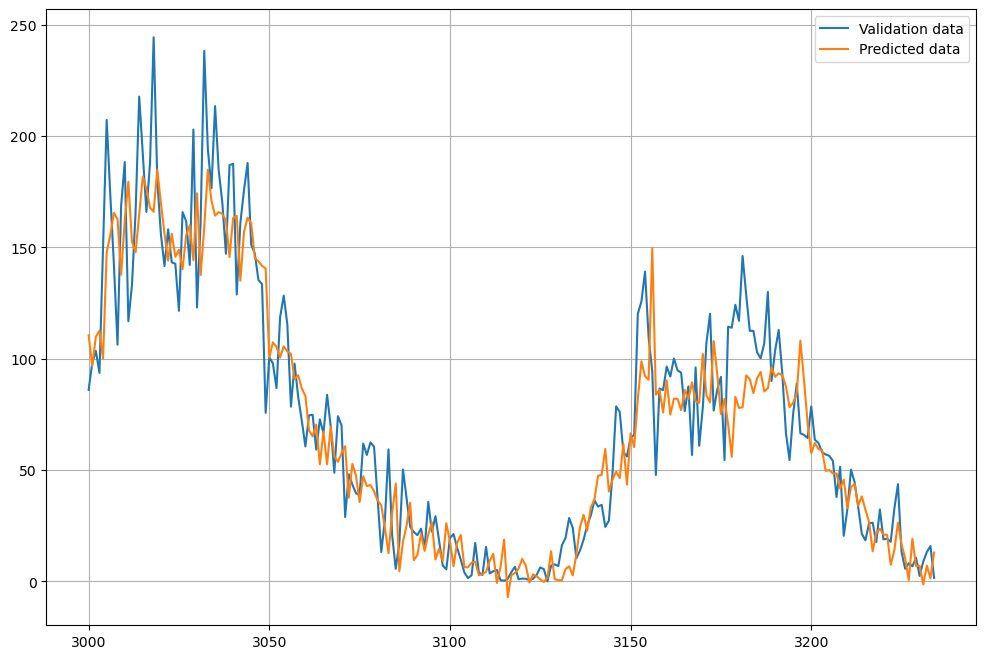

In [28]:
forecast_series = series[split_time-WINDOW_SIZE:-1]

forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

results = forecast.squeeze()

plot_series(time_val, (series_val, results), legend=('Validation data', 'Predicted data'))

In [29]:
# Implement our validation data and the model result to get the mse and mae
mse, mae = compute_metrics(series_val, results)

# Print the mse and mae
print(f"MSE: {mse}, MAE: {mae}")

MSE: 507.4326477050781, MAE: 16.408782958984375


The model prediction didn't improve compared from the first model. So we will stick with the CNN-LSTM model. 


In [30]:
# Get initial weights
init_weights = model.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

## Conclusion

I have conducted a `CNN-LSTM model` to predict the monthly mean total number of sunspots with a given dataset that have the number of monthly mean total sunspots recorded from January 1749 to July 2018. I used the learning rate scheduler to tune the learning rate, and trained the training dataset with `Adam` optimiser. The result showed with `MSE 478.86` and `MAE 14.73`. 

Predicting the future 100 steps with this model showed fairly acceptable result but there could be a room for improvement. 

I conducted another training using a `Simple RNN`, but the result didn't improve from our first model, so I didn't moved further more with the second model in prediction. 
